In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LSTM, Dropout, Input, Activation
from keras.optimizers import RMSprop, Adam

from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

import tensorflow as tf
%matplotlib notebook

Using TensorFlow backend.


In [2]:
print(np.__version__)
print(pd.__version__)
print(tf.__version__)
print(keras.__version__)

1.13.3
0.20.3
1.4.0-rc0
2.0.8


In [3]:
# Helper functions
def updown(a,b):
    # test if next time step is higher or lower
    if a < b:
        return 1
    else:
        return 0
    
def normalise_windows(window_data):
    # normalize each window of prices with the 1st price as base
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [4]:
# load csv as np array
raw = np.loadtxt(open('n225a.csv'), delimiter=',')
len(raw)

13009

In [5]:
type(raw), raw[0], raw[-1]

(numpy.ndarray, 1257.719971, 22011.609375)

In [6]:
# create list of sequences/window of length seqlen
seqlen=20
window = []
for i in range(len(raw)-seqlen):
    window.append(raw[i:i+seqlen])

In [7]:
# convert window to np.array
window_array = np.array(window)

In [8]:
# quick check on window_array type, len, and 1st element
type(window_array), len(window_array),window_array[0], len(window_array[0])

(numpy.ndarray,
 12989,
 array([ 1257.719971,  1263.98999 ,  1274.27002 ,  1286.430054,
         1288.540039,  1281.670044,  1289.5     ,  1271.680054,
         1270.339966,  1268.880005,  1270.459961,  1261.829956,
         1249.719971,  1248.050049,  1258.209961,  1247.199951,
         1242.27002 ,  1242.829956,  1238.75    ,  1248.030029]),
 20)

In [9]:
# test to see that the windows line up with the raw data
print(window_array[-1][-1] == raw[-2])
print(window_array[-2][-1] == raw[-3])
print(window_array[-3][-1] == raw[-4])

True
True
True


In [10]:
window_array[0], window_array[1], window_array[2]

(array([ 1257.719971,  1263.98999 ,  1274.27002 ,  1286.430054,
         1288.540039,  1281.670044,  1289.5     ,  1271.680054,
         1270.339966,  1268.880005,  1270.459961,  1261.829956,
         1249.719971,  1248.050049,  1258.209961,  1247.199951,
         1242.27002 ,  1242.829956,  1238.75    ,  1248.030029]),
 array([ 1263.98999 ,  1274.27002 ,  1286.430054,  1288.540039,
         1281.670044,  1289.5     ,  1271.680054,  1270.339966,
         1268.880005,  1270.459961,  1261.829956,  1249.719971,
         1248.050049,  1258.209961,  1247.199951,  1242.27002 ,
         1242.829956,  1238.75    ,  1248.030029,  1261.599976]),
 array([ 1274.27002 ,  1286.430054,  1288.540039,  1281.670044,
         1289.5     ,  1271.680054,  1270.339966,  1268.880005,
         1270.459961,  1261.829956,  1249.719971,  1248.050049,
         1258.209961,  1247.199951,  1242.27002 ,  1242.829956,
         1238.75    ,  1248.030029,  1261.599976,  1263.589966]))

In [11]:
# create y values, up or down of next time step after last time step of a window
y_check = []
for w in range(len(raw)):
    w_a = raw[w-1]
    w_b = raw[w]
    check_updown = updown(w_a,
                          w_b)
    y_check.append((check_updown, w_a, w_b))
len(y_check)

13009

In [12]:
y1 = y_check[20:]
len(y1),y1[-3:]

(12989,
 [(1, 21739.779297000001, 22008.449218999998),
  (1, 22008.449218999998, 22011.669922000001),
  (0, 22011.669922000001, 22011.609375)])

In [13]:
window_array[-1][-1], raw[-2], raw[-1]

(22011.669922000001, 22011.669922000001, 22011.609375)

In [14]:
# create y values, up or down of next time step after last time step of a window
y = []
for w in range(len(raw)):
    w_a = raw[w-1]
    w_b = raw[w]
    check_updown = updown(w_a,
                          w_b)
    y.append(check_updown)
y=y[seqlen:]
len(y)

12989

In [15]:
# check y against window_array
z = 12987
print(window_array[z])
print(y[z])
print(window_array[z+1])
raw[5:]

[ 20356.279297  20400.779297  20614.070313  20626.660156  20628.560547
  20690.710938  20823.509766  20881.269531  20954.720703  21155.179688
  21255.560547  21336.119141  21363.050781  21448.519531  21457.640625
  21696.650391  21805.169922  21707.619141  21739.779297  22008.449219]
1
[ 20400.779297  20614.070313  20626.660156  20628.560547  20690.710938
  20823.509766  20881.269531  20954.720703  21155.179688  21255.560547
  21336.119141  21363.050781  21448.519531  21457.640625  21696.650391
  21805.169922  21707.619141  21739.779297  22008.449219  22011.669922]


array([  1281.670044,   1289.5     ,   1271.680054, ...,  22008.449219,
        22011.669922,  22011.609375])

In [16]:
window_array[-1], raw[-2:],y[-5:]

(array([ 20400.779297,  20614.070313,  20626.660156,  20628.560547,
         20690.710938,  20823.509766,  20881.269531,  20954.720703,
         21155.179688,  21255.560547,  21336.119141,  21363.050781,
         21448.519531,  21457.640625,  21696.650391,  21805.169922,
         21707.619141,  21739.779297,  22008.449219,  22011.669922]),
 array([ 22011.669922,  22011.609375]),
 [0, 1, 1, 1, 0])

In [17]:
len(window_array)==len(y)

True

In [18]:
window_norm = normalise_windows(window_array)

In [19]:
len(window_norm), window_norm[0]

(12989,
 [0.0,
  0.004985226556444733,
  0.013158770935982833,
  0.022827086841256783,
  0.024504713855736382,
  0.019042452654192576,
  0.025267968810841035,
  0.011099516046406022,
  0.010034026087671899,
  0.00887322635986032,
  0.010129432857673981,
  0.0032678061053068586,
  -0.006360716363308816,
  -0.007688453887164992,
  0.00038958592635718325,
  -0.008364357919541932,
  -0.01228409451725243,
  -0.011838895257551663,
  -0.015082825618899176,
  -0.007704371579864144])

In [20]:
type(window_norm), type(y), type(window_array)

(list, list, numpy.ndarray)

In [21]:
# convert yr and winnorm to np.array
y_array = np.array(y)
window_normarray = np.array(window_norm)

In [22]:
type(window_normarray), type(y_array), type(window_array)

(numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [23]:
window_normarray.shape, y_array.shape

((12989, 20), (12989,))

In [24]:
# concat y to winnorm(x)
y_array = np.reshape(y_array,(y_array.shape[0],1))
datxy = np.concatenate((window_normarray, y_array), axis=1)


In [25]:
datxy[0], datxy.shape 

(array([  0.00000000e+00,   4.98522656e-03,   1.31587709e-02,
          2.28270868e-02,   2.45047139e-02,   1.90424527e-02,
          2.52679688e-02,   1.10995160e-02,   1.00340261e-02,
          8.87322636e-03,   1.01294329e-02,   3.26780611e-03,
         -6.36071636e-03,  -7.68845389e-03,   3.89585926e-04,
         -8.36435792e-03,  -1.22840945e-02,  -1.18388953e-02,
         -1.50828256e-02,  -7.70437158e-03,   1.00000000e+00]), (12989, 21))

In [26]:
row = round(0.9 * datxy.shape[0])

In [27]:
train = datxy[:int(row), :]

In [28]:
np.random.shuffle(train)

In [29]:
x_train = train[:, :-1]
y_train = train[:, -1]

In [30]:
y_train[:10]

array([ 0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.])

In [31]:
x_train[0],len(x_train[0])

(array([ 0.        , -0.0138032 , -0.01561255, -0.00799615, -0.0019248 ,
         0.00593941,  0.00266885,  0.00186208,  0.01807046,  0.01990617,
         0.01113961,  0.01144592,  0.00080739,  0.00063858, -0.00461477,
        -0.00166113,  0.00833882,  0.01057003,  0.01623475,  0.02341351]), 20)

In [32]:
x_test = datxy[int(row):, :-1]
y_test = datxy[int(row):, -1]

In [33]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) 

In [34]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((11690, 20, 1), (11690,), (1299, 20, 1), (1299,))

In [35]:
print('Input shape is: ', x_train.shape[1], x_train.shape[2])

Input shape is:  20 1


In [36]:
# define the input shape
inp = Input(shape=(x_train.shape[1], x_train.shape[2]))

x = LSTM(32, return_sequences = True)(inp) 
x = Dropout(0.2)(x)
x = LSTM(64, return_sequences = False)(x)
x = Dropout(0.2)(x)
output = Dense(1, activation ='sigmoid')(x)

model = Model(inputs = inp, outputs=output )

In [37]:
#optimizer = RMSprop(lr=0.01)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 1)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 32)            4352      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 29,249
Trainable params: 29,249
Non-trainable params: 0
_________________________________________________________________


In [39]:
history = model.fit(x_train, y_train,
                    batch_size = 64, 
                    epochs=200, 
                    verbose=1, 
                    validation_data=(x_test, y_test))

Train on 11690 samples, validate on 1299 samples
Epoch 1/200
11690/11690 [==============================] - 8s - loss: 0.6926 - acc: 0.5153 - val_loss: 0.6902 - val_acc: 0.5396
Epoch 2/200
11690/11690 [==============================] - 7s - loss: 0.6923 - acc: 0.5169 - val_loss: 0.6900 - val_acc: 0.5435
Epoch 3/200
11690/11690 [==============================] - 7s - loss: 0.6926 - acc: 0.5188 - val_loss: 0.6913 - val_acc: 0.5366
Epoch 4/200
11690/11690 [==============================] - 7s - loss: 0.6923 - acc: 0.5161 - val_loss: 0.6915 - val_acc: 0.5142
Epoch 5/200
11690/11690 [==============================] - 7s - loss: 0.6924 - acc: 0.5172 - val_loss: 0.6915 - val_acc: 0.5181
Epoch 6/200
11690/11690 [==============================] - 7s - loss: 0.6924 - acc: 0.5187 - val_loss: 0.6910 - val_acc: 0.5373
Epoch 7/200
11690/11690 [==============================] - 7s - loss: 0.6922 - acc: 0.5210 - val_loss: 0.6909 - val_acc: 0.5381
Epoch 8/200
11690/11690 [==============================

11690/11690 [==============================] - 7s - loss: 0.6910 - acc: 0.5283 - val_loss: 0.6920 - val_acc: 0.5266
Epoch 128/200
11690/11690 [==============================] - 7s - loss: 0.6913 - acc: 0.5270 - val_loss: 0.6923 - val_acc: 0.5227
Epoch 129/200
11690/11690 [==============================] - 7s - loss: 0.6910 - acc: 0.5263 - val_loss: 0.6937 - val_acc: 0.5273
Epoch 130/200
11690/11690 [==============================] - 7s - loss: 0.6910 - acc: 0.5255 - val_loss: 0.6921 - val_acc: 0.5227
Epoch 131/200
11690/11690 [==============================] - 7s - loss: 0.6909 - acc: 0.5250 - val_loss: 0.6932 - val_acc: 0.5073
Epoch 132/200
11690/11690 [==============================] - 7s - loss: 0.6909 - acc: 0.5217 - val_loss: 0.6933 - val_acc: 0.5296
Epoch 133/200
11690/11690 [==============================] - 7s - loss: 0.6913 - acc: 0.5254 - val_loss: 0.6915 - val_acc: 0.5242
Epoch 134/200
11690/11690 [==============================] - 7s - loss: 0.6910 - acc: 0.5253 - val_loss:

In [40]:
def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

<IPython.core.display.Javascript object>


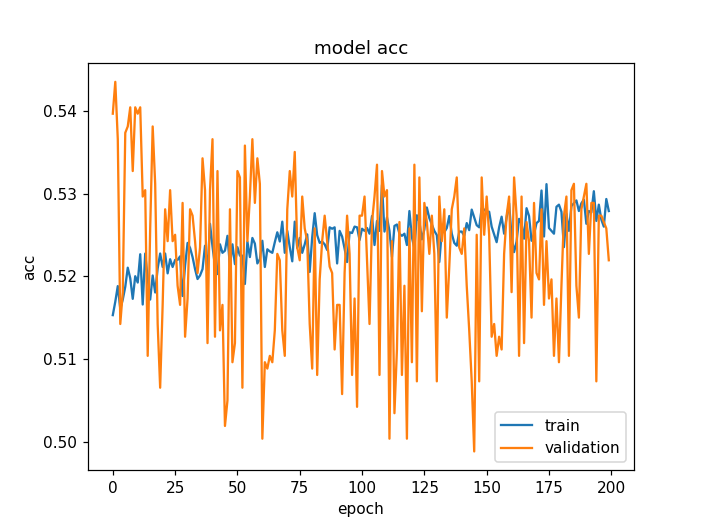

In [41]:
plot_train(history)

In [42]:
evaluation = model.evaluate(x_test, y_test, batch_size=512)
print('Model Accuracy = {:.2f} %'.format(evaluation[1]*100))
print('Model Loss = {:05.2f}'.format(evaluation[0]))

1299/1299 [==============================] - 0s     
Model Accuracy = 52.19 %
Model Loss = 00.69
